Model might be misspecified -- want to maximize where say, there are 1 or two more of the majority party. 

In [277]:
using Revise
using Pkg; Pkg.activate(".")
using HypergraphModularity

using DataFrames
using CSV
using Clustering

using StatsBase

using Plots

using SpecialFunctions

using Distances
using MultivariateStats

using RCall

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


## Read and Prepare Data

In [278]:
path = "data/congress-committees/senate_committees.csv"

function readCommittees(path)
    DF = DataFrame!(CSV.File(path));
    
    sub = combine(groupby(DF, :new_id)) do sdf
               sdf[argmax(sdf.new_id), :]
               end

    Z = sub[:, "party"];

    E = Dict()

    for sub ∈ groupby(DF, [:session, :committee])
        e = sub[!,:new_id]
        k = length(e)
        if !(k ∈ keys(E))
            E[k] = Dict()
        end
        E[k][e] = get(E[k], e, 0) + 1
    end

    for k in 1:maximum(keys(E))
        if !(k ∈ keys(E))
            E[k] = Dict()
        end
    end

    N = unique(DF[!, :new_id])

    H = hypergraph(N = N, E = E)

    HypergraphModularity.computeDegrees!(H);
    
    return H, Z
end

readCommittees (generic function with 1 method)

In [279]:
H, Z = readCommittees(path)

for k in keys(H.E)
    if k > 35
        pop!(H.E, k, 0)
    end
end
HypergraphModularity.computeDegrees!(H)

H, Z = subHypergraph(H::hypergraph, H.D .> 0, Z)

H, Z = kcore(H, Z, 0)

n = length(H.D)

337

## $\Omega$

In [280]:
V = big(sum(H.D))

kmax = maximum(keys(H.E))

function ω(p, α)
    
    k = sum(p)
    
    δ = length(p) == 1 ? p[1] : p[1] - p[2]
    μ = k % 2 == 0 ? 2.0 : 1.0
    
    x = -μ + δ*log(μ) - logfactorial(δ)
    x = exp(x)

    return x^0.5/V^(α[k+kmax]*k)
#     return x^(α[k])/V^k
end

Ω = partitionIntensityFunction(ω, kmax);
α = vcat(repeat([10.0], kmax), repeat([2.0], kmax));
α = learnParameters(H, Z, Ω, α; max_iters = 10, verbose = true, tol = 1e-4);

Ω_AON = estimateΩEmpirically(H, Z; aggregator = p -> [length(p) == 1, sum(p)])

H̄ = projectedGraph(H)  

γ_u = computeDyadicResolutionParameter(H, Z; mode = "γ", weighted = false, binary = false)
γ_w = computeDyadicResolutionParameter(H, Z; mode = "γ", weighted = true, binary = false)

# also need Ω for AON, dyadic, and other dyadic

Q = -50547.815527340375


0.9992366192382868

In [281]:
Z̄ = copy(Z)
Z̄[end-10] = 3
# Z̄ = edge_perturbation(Z, 1, 3, 2);
dyadicModularity(H, Z̄, γ_u; weighted = false, binary = false), dyadicModularity(H, Z, γ_u; weighted = false, binary = false)

(-0.019969601442131654, -0.02011099461597178)

In [282]:
# computeDyadicResolutionParameter(H, Z; mode = "ω", weighted = true, binary = false)

In [283]:
function random_perturbation(Z, t, b)
    Z̄ = copy(Z)
    for j ∈ 1:length(Z)
        Z̄[j] = rand() < t ? rand(1:b) : Z̄[j]
    end
    return Z̄
end




random_perturbation (generic function with 1 method)

In [284]:
function edge_perturbation(Z, m_edges, b = 2, c = b - 1)
    Z̄ = copy(Z)
    edges = [e for k in keys(H.E) for e in keys(H.E[k])]
    sub   = rand(edges, m_edges)
    
    sub_nodes = unique([v for e in sub for v in e])
    
    swaps = [v for v in sub_nodes if Z[v] == c]
    
    # need to additionally modify to ensure 
    
    Z̄[swaps] .= b
    
    return Z̄
end

edge_perturbation (generic function with 3 methods)

In [288]:
n_rounds = 2000

ARI = zeros(n_rounds + 1)
Q = zeros(n_rounds + 1)
Q_AON = zeros(n_rounds + 1)
Q_D = zeros(n_rounds + 1)
Q_DW = zeros(n_rounds + 1)
kind = [" " for i in 1:(n_rounds + 1)]
method = [" " for i in 1:(n_rounds + 1)]
ZZ = zeros(Int, n, n_rounds+1);

Threads.@threads for i ∈ 1:n_rounds
    
    t = 0.2*rand()
    Z̄ = random_perturbation(Z, t, 3)
    
#     b, c = 1, 1
#     while b == c
#         b = rand(1:3)
#         c = rand(1:2)
#     end
#     m_edges = rand(1:4)
#     Z̄ = edge_perturbation(Z, m_edges, b);
    
    ZZ[:,i]  .= Z̄
    ARI[i]    = randindex(Z̄, Z)[1]
    Q[i]      = modularity(H, Z̄, Ω; α = α)
    Q_AON[i]  = modularity(H, Z̄, Ω_AON; α = α)
    Q_D[i]    = dyadicModularity(H, Z̄, γ_u; weighted = false, binary = false)
    Q_DW[i]   = dyadicModularity(H, Z̄, γ_w; weighted = true, binary = false)
    kind[i]   = "sample"
    method[i] = "bespoke"
end

ZZ[:,end] .= Z

ARI[end]    = randindex(Z, Z)[1]
Q[end]      = modularity(H, Z, Ω;     α = α)
Q_AON[end]  = modularity(H, Z, Ω_AON; α = α)
Q_D[end]    = dyadicModularity(H, Z, γ_u; weighted = false, binary = false)
Q_DW[end]   = dyadicModularity(H, Z, γ_w; weighted = true,  binary = false)
kind[end]   = "true"
method[end] = "bespoke"

Q_AON[Q_AON .== -Inf] .= NaN;

DF = DataFrame(ARI   = ARI, 
               Q     = Q, 
               Q_AON = Q_AON, 
               Q_D   = Q_D, 
               Q_DW  = Q_DW, kind = kind);

In [ ]:
# compute the MDS 2d projection for the sampled partitions
R = zeros(n_rounds+1, n_rounds+1)
for i ∈ 1:(n_rounds+1), j ∈ 1:(n_rounds+1)
    R[i,j] = Clustering.varinfo(ZZ[:,i], ZZ[:,j])
end

# R = 1.0 .* pairwise(Hamming(), ZZ, dims=2)


X = classical_mds(R, 2)

R"""
library(tidyverse)
tibble(x = $(X[1,:]), y = $(X[2,:])) %>%
    cbind($(DF)) %>% 
    write_csv("fig/landscape_throughput/throughput.csv")
""";

In [ ]:
R"""
library(geometry)

df <- tibble(x = $(X[1,:]), y = $(X[2,:]), Q = $Q_D, kind = $kind)

fit <- loess(Q ~ x + y, data = df, span = .1)

# df <- broom::augment(fit)

grid <- expand.grid(x = seq(min(df$x), max(df$x), by = 0.001), y = seq(min(df$y), max(df$y), by = 0.001)) %>% tibble()

ch <- convhulln(cbind(df$x, df$y))

grid <- broom::augment(fit, newdata = data.frame(grid)) %>% 
        mutate(z = .fitted)

grid["in_grid"] <- inhulln(ch, cbind(grid$x, grid$y))

grid <- grid %>% 
    mutate(z = ifelse(in_grid, z, NA)) %>% 
    filter(!is.na(z))
""";

In [ ]:
R"""

true_df <- df %>% 
    filter(kind == "true")

grid %>% 
    ggplot() + 
    aes(x = x, y = y) + 
    geom_tile(aes(fill = z)) +
    viridis::scale_fill_viridis() + 
    theme_void() + 
    geom_point(data = true_df)
"""

In [895]:
DF = @rget grid;

In [16]:
surface(DF[:,"x"], DF[:,"y"], DF[:,"z"], camera = (150, 30), alpha = 1, seriestype = :surface, antialiased = true)

ArgumentError: ArgumentError: column name :x not found in the data frame; existing most similar names are: :Q

In [722]:
py"""

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import matplotlib.tri as tri

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = $(DF[:,"x"])
y = $(DF[:,"y"])
z = $(DF[:,"z"])

triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
# Xi, Yi = np.meshgrid(xi, yi)
# print(x)
"""

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/phil/.julia/packages/PyCall/zqDXB/src/pyeval.jl:38 =# @pysym(:PyEval_EvalCode), PyPtr, (PyPtr, PyPtr, PyPtr), o, globals, locals))))) <class 'RuntimeError'>
RuntimeError('In initialize: Triangulation is invalid',)
  File "/home/phil/.julia/packages/PyCall/zqDXB/src/pyeval.jl", line 17, in <module>
    if pyversion < v"3"
  File "/usr/lib/python3/dist-packages/matplotlib/tri/triinterpolate.py", line 268, in __init__
    TriInterpolator.__init__(self, triangulation, z, trifinder)
  File "/usr/lib/python3/dist-packages/matplotlib/tri/triinterpolate.py", line 50, in __init__
    self._trifinder = trifinder or self._triangulation.get_trifinder()
  File "/usr/lib/python3/dist-packages/matplotlib/tri/triangulation.py", line 176, in get_trifinder
    self._trifinder = TrapezoidMapTriFinder(self)
  File "/usr/lib/python3/dist-packages/matplotlib/tri/trifinder.py", line 45, in __init__
    self._initialize()
  File "/usr/lib/python3/dist-packages/matplotlib/tri/trifinder.py", line 89, in _initialize
    self._cpp_trifinder.initialize()


In [200]:
path = "data/congress-committees/senate_committees.csv"

function readCommittees(path)
    DF = DataFrame!(CSV.File(path));
    
    sub = combine(groupby(DF, :new_id)) do sdf
               sdf[argmax(sdf.new_id), :]
               end

    Z = sub[:, "party"];

    E = Dict()

    for sub ∈ groupby(DF, [:session, :committee])
        e = sub[!,:new_id]
        k = length(e)
        if !(k ∈ keys(E))
            E[k] = Dict()
        end
        E[k][e] = get(E[k], e, 0) + 1
    end

    for k in 1:maximum(keys(E))
        if !(k ∈ keys(E))
            E[k] = Dict()
        end
    end

    N = unique(DF[!, :new_id])

    H = hypergraph(N = N, E = E)

    HypergraphModularity.computeDegrees!(H);
    
    return H, Z
end

readCommittees (generic function with 1 method)

In [205]:
H, Z = readCommittees(path)

for k in keys(H.E)
    if k > 20
        pop!(H.E, k, 0)
    end
end
HypergraphModularity.computeDegrees!(H)

H, Z = subHypergraph(H::hypergraph, H.D .> 0, Z)

H, Z = kcore(H, Z, 0)

(hypergraph
  N: Array{Int64}((326,)) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  317, 318, 319, 320, 321, 322, 323, 324, 325, 326]
  E: Dict{Int64,Dict}
  D: Array{Int64}((326,)) [30, 8, 4, 11, 19, 19, 19, 28, 8, 21  …  6, 4, 3, 2, 4, 4, 2, 3, 3, 1]
, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 2, 2, 1, 1, 2, 2, 1, 1, 1])

In [206]:
V = big(sum(H.D))

kmax = maximum(keys(H.E))

function ω(p, α)
    
    k = sum(p)
    
    δ = length(p) == 1 ? p[1] : p[1] - p[2]
    μ = k % 2 == 0 ? 2.0 : 1.0
    
    x = -μ + δ*log(μ) - logfactorial(δ)
    x = exp(x)

    
    return x^0.5/V^(α[k+kmax]*k)
#     return x^(α[k])/V^k
end

Ω = partitionIntensityFunction(ω, kmax);

α = vcat(repeat([10.0], kmax), repeat([2.0], kmax));

α = learnParameters(H, Z, Ω, α; max_iters = 10, verbose = true, tol = 1e-4)

modularity(H, Z, Ω;α = α)

Q = -24792.047751510716


-24792.04775151071704372079348761748090950437078307277747728595789805893683205555

In [230]:
n_rounds = 100

ARI_0 = zeros(n_rounds+1)
Q_0   = zeros(n_rounds+1)
ARI_1 = zeros(n_rounds+1)
Q_1   = zeros(n_rounds+1)

Threads.@threads for i ∈ 1:n_rounds
    Z̄ = copy(Z)
    t = 0.2*rand()
    for j ∈ 1:length(Z)
        Z̄[j] = rand() < t ? 3-Z[j] : Z[j]
    end
    
    ARI_0[i] = randindex(Z̄, Z)[1] 
    Q_0[i]   = modularity(H, Z̄, Ω; α = α)

    Ẑ = SuperNodeLouvain(H, Ω; 
                         α = α, 
                         verbose = false, 
                         scan_order = "random", 
                         Z0 = copy(Z̄));
    
    ARI_1[i] = randindex(Ẑ, Z)[1] 
    Q_1[i] = modularity(H, Ẑ, Ω; α = α)
end

ARI_1[end] = randindex(Z, Z)[1] 
Q_1[end] = modularity(H, Z, Ω; α = α)

-24792.04775151071704372079348761748090950437078307277747728595789805893683205555

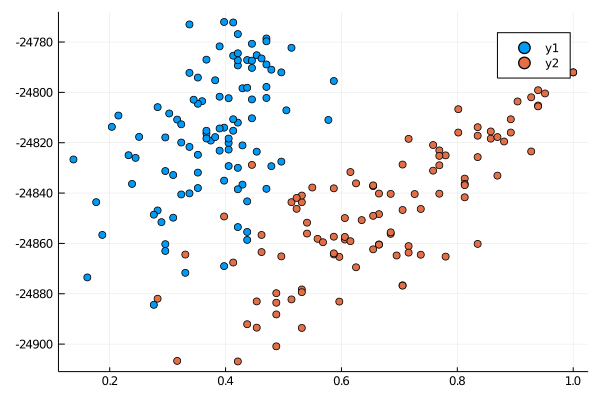

In [231]:
plot(ARI_1, Q_1, seriestype = :scatter)
plot!(ARI_0[Q_0 .< 0], Q_0[Q_0 .< 0], seriestype = :scatter)

In [222]:
randindex(Ẑ, Z)[1]

0.487564816375529

In [208]:
H̄ = projectedGraph(H)

Ω̄ = estimateΩEmpirically(H̄, Z; aggregator = p -> [length(p) == 1], bigNums = true);

modularity(H̄, Z, Ω̄; α = 0)

-260308.8605368596752729040940778227478467758382858811675313924885802705388285407

In [373]:
n = length(Z)

n_rounds = 1000

ZZ = zeros(Int, n, n_rounds+1)

Q = zeros(n_rounds+1)
Q_D = zeros(n_rounds+1)
ARI = zeros(n_rounds+1)
Threads.@threads for i ∈ 1:n_rounds
    Z̄ = copy(Z)
    t = 0.2*rand()
    for j ∈ 1:length(Z)
        Z̄[j] = rand() < t ? 3-Z[j] : Z[j]
    end
    ZZ[:,i] .= Z̄
    Q[i] = modularity(H, Z̄, Ω;α = α)
    Q_D[i] = modularity(H̄, Z̄, Ω̄; α = 0)
    
    ARI[i] = randindex(Z, Z̄)[1]
end

ZZ[:,n_rounds + 1] = Z
Q[n_rounds+1] = modularity(H, Z, Ω;α = α)
Q_D[n_rounds+1] = modularity(H̄, Z, Ω̄;α = 0)
ARI[n_rounds+1] = randindex(Z, Z)[1]

1.0

In [375]:

# X = X';

┌ Warning: `classical_mds(D::AbstractMatrix, p::Int)` is deprecated, use `transform(fit(MDS, D, maxoutdim = p, distances = true))` instead.
│   caller = top-level scope at In[375]:1
└ @ Core In[375]:1


In [387]:
S = Spline2D(X[1,:], X[2,:], Q; s = 10000000, kx = 5, ky = 5)

Spline2D([-0.1942433111626113, -0.1942433111626113, -0.1942433111626113, -0.1942433111626113, -0.1942433111626113, -0.1942433111626113, 0.43688134096736997, 0.43688134096736997, 0.43688134096736997, 0.43688134096736997, 0.43688134096736997, 0.43688134096736997], [-0.3627228451079652, -0.3627228451079652, -0.3627228451079652, -0.3627228451079652, -0.3627228451079652, -0.3627228451079652, 0.24963933618516995, 0.24963933618516995, 0.24963933618516995, 0.24963933618516995, 0.24963933618516995, 0.24963933618516995], [23881.107831126414, -107280.95164580428, 108886.35864704414, -210060.92340095696, 182814.31850412634, -209536.7768750617, -56768.542903341426, 26721.43223395572, -108900.65526751278, 94693.71682223414  …  -9831.84681523632, -46782.21445631224, 288.45075159368065, -46537.57062704191, -29571.055198481794, -18743.842999057186, -33715.48669720376, -13075.52097816465, -37566.149530010785, -14665.644419759386], 5, 5, 290947.3423101118)

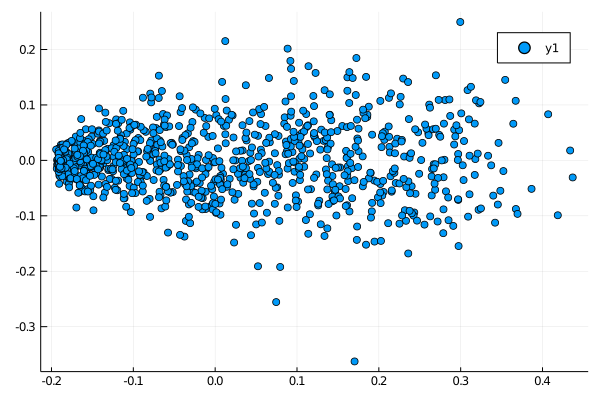

In [388]:
plot(X[1,:], X[2,:], seriestype = :scatter)

In [389]:
G = evalgrid(S, sort(X[1,:]), sort(X[2,:]));

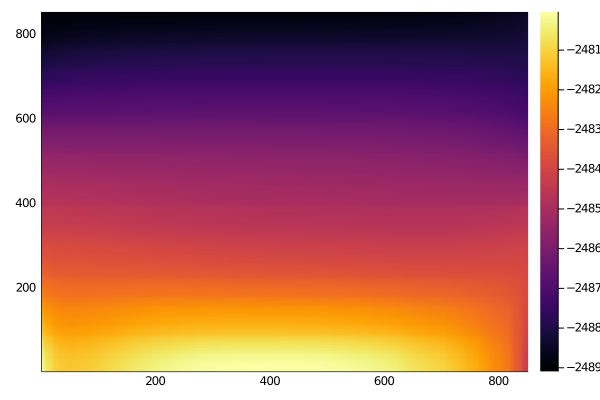

In [399]:
heatmap(G[75:925, 75:925])

In [178]:
R"""
library(tidyverse)
library(akima)
df <- tibble(x = $(X[:,1]), y = $(X[:,2]), Q = $(Q)) %>% 
    mutate(true = row_number() == max(row_number()))

fld <- with(df, interp(x = x, y = y, z = Q, duplicate = "mean", nx = 200, ny = 200, linear = T, extrap = FALSE, jitter = 1))

dimnames(fld$z) <- list(1:dim(fld$z)[1], 1:dim(fld$z)[2])
fld
""";

In [179]:
minimum(X[:,1]), maximum(X[:,1])

(-0.08946476023064953, 0.125253066786334)

In [180]:
ARI[Q .== maximum(Q)]

1-element Array{Float64,1}:
 0.9755354040456753

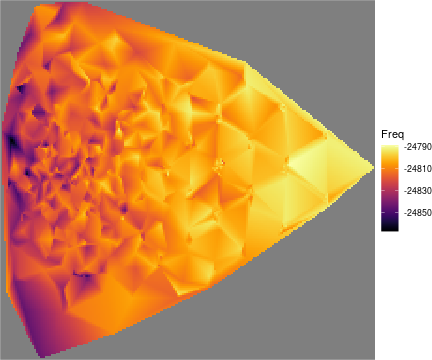

RObject{VecSxp}


In [181]:
R"""
interp_df <- as_tibble(as.data.frame(as.table(fld$z)))

raw_df <- tibble(x = $(X[:,1]), y = $(X[:,2]), Q = $Q) %>% 
    mutate(true = row_number() == max(row_number()))

true_df <- raw_df %>%
    filter(true)

interp_df %>% 
    ggplot() + 
    geom_raster(aes(x = Var1, y = Var2, fill = Freq)) + 
    theme_void() +
    viridis::scale_fill_viridis(option = "inferno")
"""

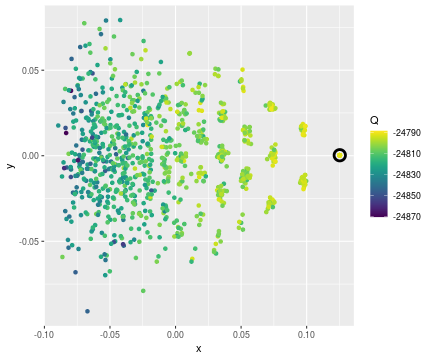

RObject{VecSxp}


In [182]:
R"""
library(tidyverse)
df <- tibble(x = $(X[:,1]), y = $(X[:,2]), Q = $Q) %>% 
    mutate(true = row_number() == max(row_number()))

true_df <- df %>%
    filter(true)

df %>% 
    ggplot() + 
    aes(x = x, y = y, color = Q) + 
    geom_point() +
    geom_point(data = true_df, color = "black", pch = 21, alpha = 1, size = 4, stroke = 2) +
    viridis::scale_color_viridis()
"""

# $\Omega$

Our idea here is that we want an $\Omega$ function that actively favors splits that are roughly even. 

In [1535]:
ω([5, 5], α), Ω.ω([6, 4], α)

(1.384546286393792361781003420985992420474470080129777699678137912057154730166207e-76, 1.958044135951404717422575978644827445994496879509484763468405533710553774548446e-76)

Q = -50547.815527340375


62-element Array{Float64,1}:
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
  ⋮
  0.9737040928053698
  0.9742854714619982
  0.9768607904036358
  0.9793456533711509
  0.9823649526868441
  0.9888307508018406
  0.9853998867744479
  0.9912510253993297
  0.9882720190124189
  0.9873723947696722
  0.9898181112465736
  0.9906566999636068

In [1537]:
modularity(H, Z, Ω;α = α)

-50547.8155273403741972631188104025816512687765068524968186634151949408252568505

In [ ]:
Ẑ = SuperNodeLouvain(H, Ω; 
                     α = α, 
                     verbose = true, 
                     scan_order = "random", 
                     Z0 = rand([1, 2], length(H.D)));

Faster SuperNode Louvain: Phase 1
Louvain Iteration 1, Q = -50867.76


In [1517]:
Z̄ = copy(Z)
t = 0.1
for i in 1:length(Z)
    Z̄[i] = rand() < t ? 3-Z[i] : Z[i]
end
round(Float64(modularity(H, Z̄, Ω;α = α)), digits = 2), randindex(Z̄, Z)[1]

(-50731.95, 0.5712835835539724)

In [1518]:
Ẑ = SuperNodeLouvain(H, Ω; α = α, verbose = true, scan_order = "random", Z0 = Z̄);

Faster SuperNode Louvain: Phase 1
Louvain Iteration 1, Q = -50731.95
Louvain Iteration 2, Q = -50705.7
Louvain Iteration 3, Q = -50700.09
Louvain Iteration 4, Q = -50699.68
SuperNode Louvain: Phase 2
toc = 0.000843048095703125
Louvain Iteration 1
t1 = 1.4346771240234375


In [1521]:
# ok interesting, local  max is largely uncorrelated with true labels....
# that is a bummer =(. Does adding more edges help? 

round(Float64(modularity(H, Ẑ, Ω;α = α)), digits = 2), randindex(Ẑ, Z)[1]

(-50699.68, 0.47646858176251405)

In [1522]:
# true value

round(Float64(modularity(H, Z, Ω;α = α)), digits = 2), randindex(Z, Z)[1]

(-50547.82, 1.0)

In [1531]:
n_rounds = 200

Q = zeros(n_rounds)
ARI = zeros(n_rounds)

for i ∈ 1:n_rounds
    Z̄ = copy(Z)
    t = 0.1*rand()
    for j ∈ 1:length(Z)
        Z̄[j] = rand() < t ? 3-Z[j] : Z[j]
    end
    Q[i] = modularity(H, Z̄, Ω;α = α)
    ARI[i] = randindex(Z, Z̄)[1]
end

In [1532]:
using RCall

R"""
library(tidyverse)
"""

RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"     


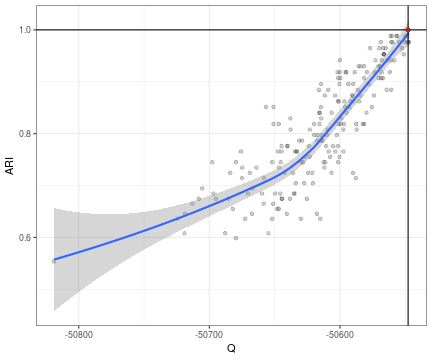

RObject{VecSxp}


┌ Warning: RCall.jl: `geom_smooth()` using method = 'loess' and formula 'y ~ x'
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [1533]:
R"""
df <- tibble(Q = $Q, ARI = $(ARI))

best_df <- tibble(Q = $(modularity(H, Z, Ω; α =α)), ARI = $(randindex(Z, Z)[1]))

df %>% 
    ggplot() + 
    aes(x = Q, y = ARI) + 
    geom_point(alpha = 0.2) + 
#    xlim(max(df$Q) - 5, max(best_df$Q)) + 
    geom_smooth() + 
    geom_hline(aes(yintercept = 1)) + 
    geom_vline(aes(xintercept = best_df$Q[1])) + 
    geom_point(data = best_df, color = "firebrick") + 
    theme_bw()
"""

# Synthetic

Can we do this when we have a fake hypergraph?

In [1183]:
n = 100

kmax = 4

Z = rand(1:2, n)

function ω(p, α)
    k = sum(p)
    x = 4*prod(p) / k^2
    return 0.5*x^5/n^(α[k+kmax]*k)*k^9
end

Ω = partitionIntensityFunction(ω, kmax);

α = vcat(repeat([10.0], kmax), repeat([.1], kmax));

ϑ =  1000000000*dropdims(ones(1,n) + rand(1,n), dims = 1)

H = sampleSBM(Z, ϑ, Ω;α=α0, kmax=kmax, kmin = 1)

hypergraph
  N: Array{Int64}((100,)) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
  E: Dict{Int64,Dict}
  D: Array{Int64}((100,)) [9, 7, 7, 3, 13, 5, 6, 4, 5, 3  …  7, 8, 6, 1, 9, 12, 7, 6, 2, 2]


In [1184]:
mean(H.D)

5.77

In [1185]:
[length(H.E[k]) for k in 1:maximum(keys(H.E))]

4-element Array{Int64,1}:
  55
 100
  54
  40

In [1186]:
α = learnParameters(H, Z, Ω, α; max_iters = 10, verbose = true, tol = 1e-4);
round(modularity(H, Z, Ω;α = α)), randindex(Z, Z)[1]

Q = -2878.0809048283973


(-2878.0, 1.0)

In [1211]:
Z̄ = copy(Z)
t = 0.1
for i in 1:length(Z)
    Z̄[i] = rand() < t ? 3-Z[i] : Z[i]
end
round(modularity(H, Z̄, Ω;α = α)), randindex(Z̄, Z)[1]

(-2954.0, 0.6044056963032804)

In [1212]:
Ẑ = SuperNodeLouvain(H, Ω; α = α, verbose = false, scan_order = "random", Z0 = Z̄);

In [1213]:
# ok interesting, local  max is largely uncorrelated with true labels....
# that is a bummer =(. Does adding more edges help? 

round(Float64(modularity(H, Ẑ, Ω;α = α)), digits = 2), randindex(Ẑ, Z)[1]

(-2876.4, 0.6363294399767251)

In [1545]:
Pkg.add("Distances")

  Resolving package versions...
   Updating `~/hypergraph_modularities_code/Project.toml`
  [b4f34e82] + Distances v0.9.0
   Updating `~/hypergraph_modularities_code/Manifest.toml`
 [no changes]
